# Post-Fire Vegetation Recovery Demonstration

This notebook demonstrates the complete post-fire decision support workflow using the Josh simulation engine.

## Workflow Overview

1. **Generate External Data** (Python): Create synthetic fire severity and management intervention rasters
2. **Visualize Input Data** (Python): Verify rasters look correct
3. **Preprocess Data** (Bash): Convert GeoTIFFs to Josh `.jshd` format
4. **Run Cold-Start** (Bash): Equilibrate the system for 1000 years
5. **Run Scenarios** (Bash): Execute 5 scenarios with 100 replicates each
6. **Analysis** (R): Visualize results with ggplot2 (separate script)

## Ecological System

- **Native Trees**: Individual agents with 3 life stages (seedling → juvenile → adult)
- **Invasive Grass**: Patch-level cover percentage that competes with tree establishment
- **Fire**: Kills trees based on severity and life stage; temporarily reduces invasive cover
- **Management**: Seeding (add seedlings) and invasive removal (reduce cover)

## Spatial Configuration

- **Grid**: 30 × 30 patches (900 total)
- **Patch size**: 10m × 10m
- **Total extent**: 300m × 300m
- **Coordinates**: Local metric system (meters)

---
## Section 1: Setup and Parameters

In [1]:
# Required packages
import numpy as np
import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import os

# Ensure output directories exist
os.makedirs('data', exist_ok=True)
os.makedirs('preprocessed', exist_ok=True)
for scenario in ['coldstart', 'baseline', 'fire_only', 'fire_seeding', 'fire_removal', 'fire_both']:
    os.makedirs(f'results/{scenario}', exist_ok=True)

print("Setup complete!")

Setup complete!


In [ ]:
# =============================================================================
# SPATIAL PARAMETERS
# =============================================================================

# Grid dimensions (must match Josh model)
N_ROWS = 30
N_COLS = 30

# Geographic bounds in WGS84 degrees (must match Josh model)
# Note: In WGS84, latitude decreases going south. Josh expects:
#   grid.low = top-left (high lat), grid.high = bottom-right (low lat)
# For rasters, we use standard orientation: Y increases upward
LON_LOW, LON_HIGH = 0.0, 0.003  # longitude direction (degrees)
LAT_LOW, LAT_HIGH = 0.0, 0.003  # latitude direction (degrees)

# For visualization (meters approximation: 0.0001° ≈ 11m at equator)
X_LOW, X_HIGH = 0, 300  # approximate meters for display
Y_LOW, Y_HIGH = 0, 300  # approximate meters for display

# Raster transform (maps pixel coordinates to degree coordinates)
TRANSFORM = from_bounds(LON_LOW, LAT_LOW, LON_HIGH, LAT_HIGH, N_COLS, N_ROWS)

# Common raster profile - using WGS84 (degrees)
BASE_PROFILE = {
    'driver': 'GTiff',
    'width': N_COLS,
    'height': N_ROWS,
    'count': 1,
    'crs': CRS.from_epsg(4326),  # WGS84 (degrees)
    'transform': TRANSFORM,
}

print(f"Grid: {N_ROWS} x {N_COLS} = {N_ROWS * N_COLS} patches")
print(f"Extent: {LON_LOW}° to {LON_HIGH}° lon × {LAT_LOW}° to {LAT_HIGH}° lat")
print(f"Approximate size: ~300m × ~300m (at equator)")
print(f"CRS: EPSG:4326 (WGS84)")

In [3]:
# =============================================================================
# SIMULATION PARAMETERS
# =============================================================================

# Temporal settings
COLD_START_YEARS = 1000
SCENARIO_YEARS = 50
N_REPLICATES = 100

# Fire parameters
FIRE_CENTER = (N_ROWS // 2, N_COLS // 2)  # Center of grid
FIRE_SIGMA = 7  # Standard deviation in grid cells (larger for 30x30)
FIRE_MAX_SEVERITY = 0.95  # Peak severity at center
FIRE_NOISE_SCALE = 0.25  # Amount of noise to add (0-1)
FIRE_NOISE_SEED = 42  # For reproducibility

# Seeding parameters
SEEDING_MIN_SEVERITY = 0.3  # Only seed in moderate+ severity
SEEDING_MAX_SEVERITY = 0.7  # Don't seed in highest severity (too damaged)
SEEDING_INTENSITY = 5  # Seedlings per patch

# Removal parameters
REMOVAL_MIN_SEVERITY = 0.5  # Only remove in high severity areas

print(f"Cold-start: {COLD_START_YEARS} years")
print(f"Scenarios: {SCENARIO_YEARS} years x {N_REPLICATES} replicates")
print(f"Fire noise scale: {FIRE_NOISE_SCALE} (adds natural variability)")

Cold-start: 1000 years
Scenarios: 50 years x 100 replicates
Fire noise scale: 0.25 (adds natural variability)


---
## Section 2: Generate External Data

In [4]:
# =============================================================================
# FIRE SEVERITY RASTER (with realistic noise)
# =============================================================================

def generate_fire_severity(n_rows, n_cols, center, sigma, max_severity, 
                           noise_scale=0.2, seed=None):
    """
    Generate a noisy 2D Gaussian fire severity pattern.
    
    The base Gaussian is perturbed with spatially-correlated noise to simulate
    real fire behavior where terrain, fuel load, and wind create irregular patterns.
    
    Parameters:
    - n_rows, n_cols: Grid dimensions
    - center: (row, col) tuple for fire center
    - sigma: Standard deviation (spread of fire)
    - max_severity: Peak severity at center (0-1)
    - noise_scale: Amount of noise (0=none, 1=fully random)
    - seed: Random seed for reproducibility
    
    Returns:
    - 2D numpy array of severity values (0-1)
    """
    if seed is not None:
        np.random.seed(seed)
    
    y, x = np.ogrid[:n_rows, :n_cols]
    center_y, center_x = center
    
    # Base 2D Gaussian
    distance_sq = (y - center_y)**2 + (x - center_x)**2
    base_severity = max_severity * np.exp(-distance_sq / (2 * sigma**2))
    
    # Generate spatially-correlated noise using smoothed random field
    # Start with random noise
    raw_noise = np.random.randn(n_rows, n_cols)
    
    # Smooth it with a simple box filter to create spatial correlation
    from scipy.ndimage import uniform_filter
    smooth_noise = uniform_filter(raw_noise, size=5, mode='reflect')
    
    # Normalize to [-1, 1] range
    smooth_noise = smooth_noise / (np.abs(smooth_noise).max() + 1e-10)
    
    # Add directional bias (simulates wind effect - fire spreads more in one direction)
    wind_direction = np.random.uniform(0, 2 * np.pi)
    wind_strength = 0.3
    wind_effect = wind_strength * (
        np.cos(wind_direction) * (x - center_x) / n_cols +
        np.sin(wind_direction) * (y - center_y) / n_rows
    )
    
    # Combine base Gaussian with noise
    # Noise effect is stronger where base severity is moderate (fire edges)
    edge_factor = 4 * base_severity * (1 - base_severity)  # Peaks at 0.5
    noise_contribution = noise_scale * smooth_noise * edge_factor
    
    # Add wind effect (shifts the pattern slightly)
    severity = base_severity * (1 + wind_effect) + noise_contribution
    
    # Clamp to valid range
    severity = np.clip(severity, 0, 1)
    
    return severity.astype(np.float32)

# Generate fire severity
fire_severity = generate_fire_severity(
    N_ROWS, N_COLS, 
    FIRE_CENTER, 
    FIRE_SIGMA, 
    FIRE_MAX_SEVERITY,
    noise_scale=FIRE_NOISE_SCALE,
    seed=FIRE_NOISE_SEED
)

# Save to GeoTIFF
fire_profile = BASE_PROFILE.copy()
fire_profile['dtype'] = 'float32'
fire_profile['nodata'] = -9999

with rasterio.open('data/fire_severity.tif', 'w', **fire_profile) as dst:
    dst.write(fire_severity, 1)

print(f"Fire severity range: {fire_severity.min():.3f} to {fire_severity.max():.3f}")
print(f"High severity (>0.7) patches: {(fire_severity > 0.7).sum()}")
print(f"Moderate severity (0.3-0.7) patches: {((fire_severity > 0.3) & (fire_severity <= 0.7)).sum()}")
print(f"Low severity (<0.3) patches: {(fire_severity <= 0.3).sum()}")
print("Saved: data/fire_severity.tif")

Fire severity range: 0.009 to 0.951
High severity (>0.7) patches: 99
Moderate severity (0.3-0.7) patches: 252
Low severity (<0.3) patches: 549
Saved: data/fire_severity.tif


In [5]:
# =============================================================================
# SEEDING INTENSITY RASTER
# =============================================================================

def generate_seeding_intensity(fire_severity, min_sev, max_sev, intensity):
    """
    Generate seeding locations based on fire severity.
    Seeds are planted in moderate-severity areas.
    
    Parameters:
    - fire_severity: 2D array of severity values
    - min_sev, max_sev: Severity range for seeding
    - intensity: Number of seedlings per patch
    
    Returns:
    - 2D numpy array of seeding intensity (integer)
    """
    # Target moderate severity ring
    in_range = (fire_severity > min_sev) & (fire_severity <= max_sev)
    seeding = np.where(in_range, intensity, 0)
    
    return seeding.astype(np.int16)

# Generate seeding intensity
seeding_intensity = generate_seeding_intensity(
    fire_severity,
    SEEDING_MIN_SEVERITY,
    SEEDING_MAX_SEVERITY,
    SEEDING_INTENSITY
)

# Save to GeoTIFF
seeding_profile = BASE_PROFILE.copy()
seeding_profile['dtype'] = 'int16'
seeding_profile['nodata'] = -1

with rasterio.open('data/seeding_intensity.tif', 'w', **seeding_profile) as dst:
    dst.write(seeding_intensity, 1)

print(f"Seeding intensity range: {seeding_intensity.min()} to {seeding_intensity.max()}")
print(f"Patches with seeding: {(seeding_intensity > 0).sum()}")
print(f"Total seedlings to plant: {seeding_intensity.sum()}")
print("Saved: data/seeding_intensity.tif")

Seeding intensity range: 0 to 5
Patches with seeding: 252
Total seedlings to plant: 1260
Saved: data/seeding_intensity.tif


In [6]:
# =============================================================================
# INVASIVE REMOVAL RASTER
# =============================================================================

def generate_removal_intensity(fire_severity, min_sev):
    """
    Generate invasive removal locations based on fire severity.
    Removal targets high-severity areas where invasives will dominate.
    
    Parameters:
    - fire_severity: 2D array of severity values
    - min_sev: Minimum severity for removal treatment
    
    Returns:
    - 2D numpy array of removal flags (0 or 1)
    """
    removal = np.where(fire_severity > min_sev, 1, 0)
    return removal.astype(np.int16)

# Generate removal intensity
removal_intensity = generate_removal_intensity(
    fire_severity,
    REMOVAL_MIN_SEVERITY
)

# Save to GeoTIFF
removal_profile = BASE_PROFILE.copy()
removal_profile['dtype'] = 'int16'
removal_profile['nodata'] = -1

with rasterio.open('data/removal_intensity.tif', 'w', **removal_profile) as dst:
    dst.write(removal_intensity, 1)

print(f"Removal intensity range: {removal_intensity.min()} to {removal_intensity.max()}")
print(f"Patches with removal treatment: {(removal_intensity > 0).sum()}")
print("Saved: data/removal_intensity.tif")

Removal intensity range: 0 to 1
Patches with removal treatment: 194
Saved: data/removal_intensity.tif


---
## Section 3: Visualize Input Data

Verify that the generated rasters look correct before preprocessing.

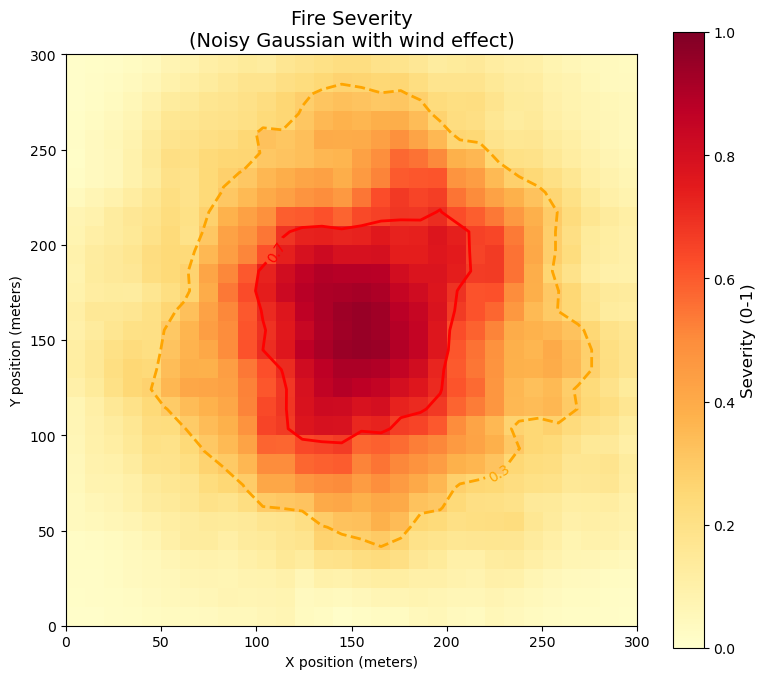


Contour lines show severity thresholds:
  - Orange dashed (0.3): Low/moderate boundary
  - Red solid (0.7): Moderate/high boundary


In [7]:
# =============================================================================
# VISUALIZATION: FIRE SEVERITY
# =============================================================================

fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(fire_severity, cmap='YlOrRd', vmin=0, vmax=1, origin='lower',
               extent=[X_LOW, X_HIGH, Y_LOW, Y_HIGH])
ax.set_title('Fire Severity\n(Noisy Gaussian with wind effect)', fontsize=14)
ax.set_xlabel('X position (meters)')
ax.set_ylabel('Y position (meters)')

# Add contour lines for severity thresholds
contours = ax.contour(np.linspace(X_LOW, X_HIGH, N_COLS), 
                      np.linspace(Y_LOW, Y_HIGH, N_ROWS),
                      fire_severity, levels=[0.3, 0.7], colors=['orange', 'red'], 
                      linestyles=['--', '-'], linewidths=2)
ax.clabel(contours, inline=True, fontsize=10, fmt='%.1f')

cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Severity (0-1)', fontsize=12)

plt.tight_layout()
plt.savefig('data/fire_severity_preview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nContour lines show severity thresholds:")
print("  - Orange dashed (0.3): Low/moderate boundary")
print("  - Red solid (0.7): Moderate/high boundary")

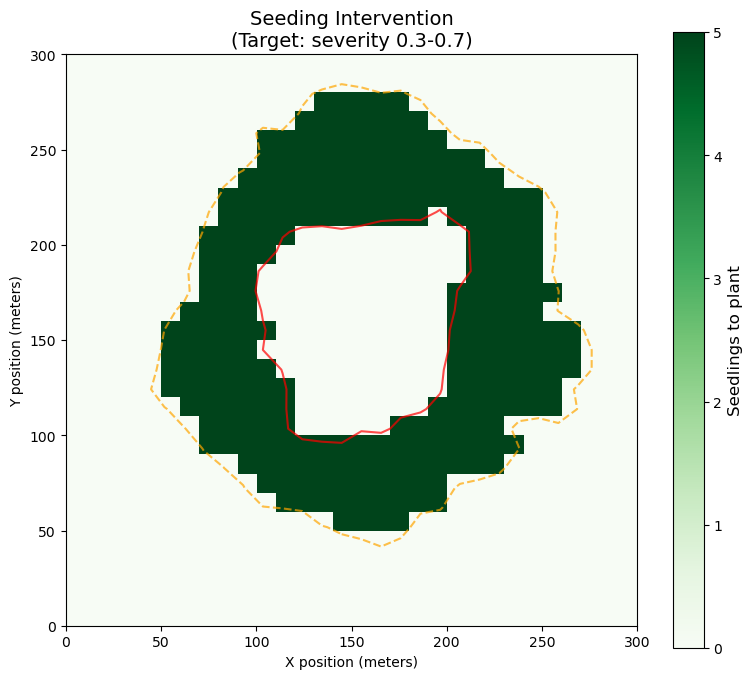


Seeding targets the 'ring' of moderate severity
(between orange and red contours)


In [8]:
# =============================================================================
# VISUALIZATION: SEEDING LOCATIONS
# =============================================================================

fig, ax = plt.subplots(figsize=(8, 8))

# Show seeding intensity
im = ax.imshow(seeding_intensity, cmap='Greens', vmin=0, vmax=SEEDING_INTENSITY, origin='lower',
               extent=[X_LOW, X_HIGH, Y_LOW, Y_HIGH])
ax.set_title(f'Seeding Intervention\n(Target: severity {SEEDING_MIN_SEVERITY}-{SEEDING_MAX_SEVERITY})', fontsize=14)
ax.set_xlabel('X position (meters)')
ax.set_ylabel('Y position (meters)')

# Overlay fire severity contours for reference
contours = ax.contour(np.linspace(X_LOW, X_HIGH, N_COLS),
                      np.linspace(Y_LOW, Y_HIGH, N_ROWS),
                      fire_severity, levels=[0.3, 0.7], colors=['orange', 'red'], 
                      linestyles=['--', '-'], linewidths=1.5, alpha=0.7)

cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Seedlings to plant', fontsize=12)

plt.tight_layout()
plt.savefig('data/seeding_intensity_preview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSeeding targets the 'ring' of moderate severity")
print("(between orange and red contours)")

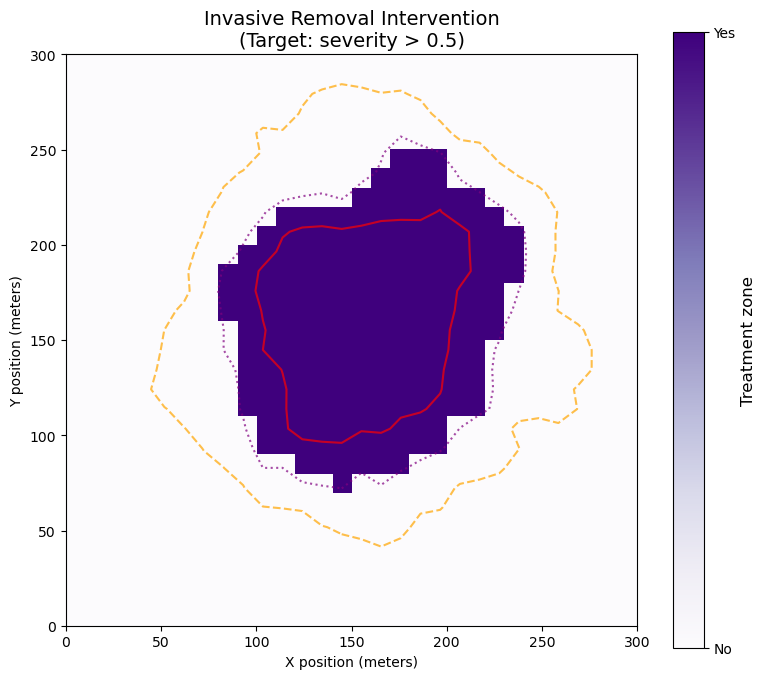


Removal targets the core of high severity
(inside purple dotted contour, severity > 0.5)


In [9]:
# =============================================================================
# VISUALIZATION: REMOVAL LOCATIONS
# =============================================================================

fig, ax = plt.subplots(figsize=(8, 8))

# Show removal zones
im = ax.imshow(removal_intensity, cmap='Purples', vmin=0, vmax=1, origin='lower',
               extent=[X_LOW, X_HIGH, Y_LOW, Y_HIGH])
ax.set_title(f'Invasive Removal Intervention\n(Target: severity > {REMOVAL_MIN_SEVERITY})', fontsize=14)
ax.set_xlabel('X position (meters)')
ax.set_ylabel('Y position (meters)')

# Overlay fire severity contours for reference
contours = ax.contour(np.linspace(X_LOW, X_HIGH, N_COLS),
                      np.linspace(Y_LOW, Y_HIGH, N_ROWS),
                      fire_severity, levels=[0.3, 0.5, 0.7], colors=['orange', 'purple', 'red'], 
                      linestyles=['--', ':', '-'], linewidths=1.5, alpha=0.7)

cbar = plt.colorbar(im, ax=ax, shrink=0.8, ticks=[0, 1])
cbar.set_label('Treatment zone', fontsize=12)
cbar.ax.set_yticklabels(['No', 'Yes'])

plt.tight_layout()
plt.savefig('data/removal_intensity_preview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nRemoval targets the core of high severity")
print("(inside purple dotted contour, severity > 0.5)")

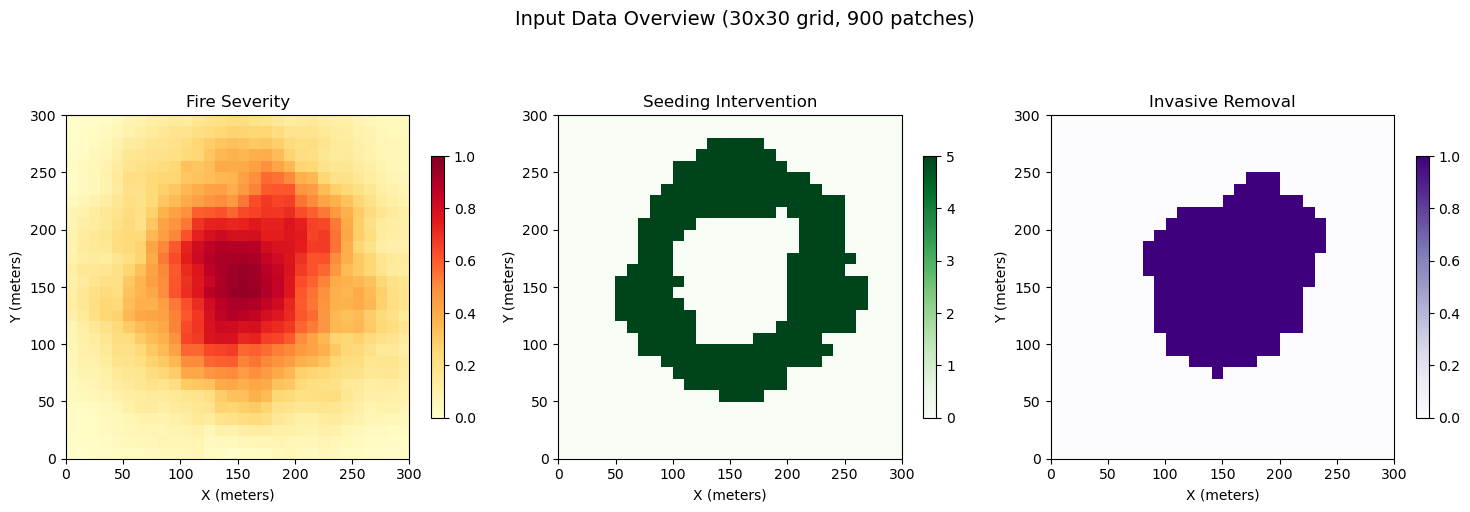

In [10]:
# =============================================================================
# COMBINED OVERVIEW
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

extent = [X_LOW, X_HIGH, Y_LOW, Y_HIGH]

# Fire severity
im1 = axes[0].imshow(fire_severity, cmap='YlOrRd', vmin=0, vmax=1, origin='lower', extent=extent)
axes[0].set_title('Fire Severity', fontsize=12)
plt.colorbar(im1, ax=axes[0], shrink=0.6)

# Seeding
im2 = axes[1].imshow(seeding_intensity, cmap='Greens', vmin=0, vmax=SEEDING_INTENSITY, origin='lower', extent=extent)
axes[1].set_title('Seeding Intervention', fontsize=12)
plt.colorbar(im2, ax=axes[1], shrink=0.6)

# Removal
im3 = axes[2].imshow(removal_intensity, cmap='Purples', vmin=0, vmax=1, origin='lower', extent=extent)
axes[2].set_title('Invasive Removal', fontsize=12)
plt.colorbar(im3, ax=axes[2], shrink=0.6)

for ax in axes:
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')

plt.suptitle(f'Input Data Overview ({N_ROWS}x{N_COLS} grid, {N_ROWS * N_COLS} patches)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('data/all_inputs_preview.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 4: Preprocess Data for Josh

Convert GeoTIFFs to Josh's optimized `.jshd` format.

**Note**: Update `JOSH_JAR` path to point to your joshsim-fat.jar location.

In [ ]:
# Path to Josh JAR file (downloaded by get_fat_jar.sh)
JOSH_JAR = "jar/joshsim-fat-prod.jar"

# Verify JAR exists
import os
if os.path.exists(JOSH_JAR):
    print(f"Found Josh JAR: {JOSH_JAR}")
else:
    print(f"WARNING: Josh JAR not found at {JOSH_JAR}")
    print("Run: bash get_fat_jar.sh")

In [ ]:
%%bash -s "$JOSH_JAR"

JOSH_JAR=$1

echo "=== Preprocessing fire severity ==="
# Note: GeoTIFF bands are 0-indexed, so use band 0 (not 1)
java -jar $JOSH_JAR preprocess vegetation_model.josh Main data/fire_severity.tif 0 ratio preprocessed/fire_severity.jshd --timestep 0

echo ""
echo "=== Preprocessing seeding intensity ==="
java -jar $JOSH_JAR preprocess vegetation_model.josh Main data/seeding_intensity.tif 0 count preprocessed/seeding_intensity.jshd --timestep 0

echo ""
echo "=== Preprocessing removal intensity ==="
java -jar $JOSH_JAR preprocess vegetation_model.josh Main data/removal_intensity.tif 0 count preprocessed/removal_intensity.jshd --timestep 0

echo ""
echo "=== Preprocessing complete ==="
ls -lh preprocessed/

echo ""
echo "=== Verifying fire severity data was loaded (center cell should be ~0.94) ==="
java -jar $JOSH_JAR inspectJshd preprocessed/fire_severity.jshd data 0 15 15

---
## Section 5: Validate Josh Model

Check that the Josh model compiles correctly before running simulations.

In [13]:
%%bash -s "$JOSH_JAR"

JOSH_JAR=$1

echo "=== Validating vegetation_model.josh ==="
java -jar $JOSH_JAR validate vegetation_model.josh

echo ""
echo "=== Discovering configuration variables ==="
java -jar $JOSH_JAR discoverConfig vegetation_model.josh

=== Validating vegetation_model.josh ===


Validated Josh code at vegetation_model.josh



=== Discovering configuration variables ===


scenario.fireOccurred(false)
scenario.invasiveRemoval(false)
scenario.seedingIntervention(false)


---
## Section 6: Run Cold-Start Equilibration

Run the model for 1000 years without fire to establish a stable initial population.

**Note**: This may take several minutes. The cold-start produces the equilibrium state that will be used as Year 0 for all scenarios.

In [ ]:
%%bash -s "$JOSH_JAR"

JOSH_JAR=$1

echo "=== Running cold-start equilibration (1000 years) ==="
echo "This may take several minutes..."
echo ""

# Copy coldstart config to working directory
cp configs/coldstart.jshc scenario.jshc

# Run cold-start (output path is configured in vegetation_model.josh)
java -jar $JOSH_JAR run \
    vegetation_model.josh Main \
    --replicates 1

echo ""
echo "=== Cold-start complete ==="
ls -lh results/

---
## Section 7: Run Scenario Simulations

Execute all 5 scenarios with 100 replicates each.

**Scenarios:**
1. `baseline` - No fire, no intervention (control)
2. `fire_only` - Fire without intervention
3. `fire_seeding` - Fire + seedling planting
4. `fire_removal` - Fire + invasive removal
5. `fire_both` - Fire + both interventions

In [ ]:
%%bash -s "$JOSH_JAR"

JOSH_JAR=$1
N_REPLICATES=100

echo "=== Running scenario simulations ==="
echo "Replicates per scenario: $N_REPLICATES"
echo ""

for SCENARIO in baseline fire_only fire_seeding fire_removal fire_both; do
    echo "--- Running scenario: $SCENARIO ---"
    
    # Copy scenario config to working directory
    cp configs/${SCENARIO}.jshc scenario.jshc
    
    # Run simulation (output path is configured in vegetation_model.josh)
    java -jar $JOSH_JAR run \
        vegetation_model.josh Main \
        --replicates $N_REPLICATES
    
    echo "Completed: $SCENARIO"
    echo ""
done

echo "=== All scenarios complete ==="
echo ""
echo "Results summary:"
ls -lh results/

---
## Section 8: Quick Results Preview (Python)

Load and preview results before detailed R analysis.

In [16]:
import pandas as pd
import glob

# Find all result files
scenarios = ['baseline', 'fire_only', 'fire_seeding', 'fire_removal', 'fire_both']

# Load sample data (first replicate of each scenario)
sample_data = {}
for scenario in scenarios:
    files = glob.glob(f'results/{scenario}/*.csv')
    if files:
        df = pd.read_csv(files[0])
        df['scenario'] = scenario
        sample_data[scenario] = df
        print(f"{scenario}: {len(files)} files, {len(df)} rows in first file")
    else:
        print(f"{scenario}: No files found")

if sample_data:
    # Show column names from first available dataset
    first_scenario = list(sample_data.keys())[0]
    print(f"\nColumns: {list(sample_data[first_scenario].columns)}")

baseline: No files found
fire_only: No files found
fire_seeding: No files found
fire_removal: No files found
fire_both: No files found


In [17]:
# Quick time series preview (if data available)
if sample_data:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for scenario, df in sample_data.items():
        # Aggregate across patches
        ts = df.groupby('step').agg({
            'totalTrees': 'sum',
            'invasiveCover': 'mean'
        }).reset_index()
        
        axes[0].plot(ts['step'], ts['totalTrees'], label=scenario)
        axes[1].plot(ts['step'], ts['invasiveCover'], label=scenario)
    
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Total Trees')
    axes[0].set_title('Tree Population Over Time (Single Replicate)')
    axes[0].legend()
    
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Mean Invasive Cover (%)')
    axes[1].set_title('Invasive Cover Over Time (Single Replicate)')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('results/quick_preview.png', dpi=150)
    plt.show()
else:
    print("No results data available for preview.")
    print("Run the simulation cells above first.")

No results data available for preview.
Run the simulation cells above first.


---
## Section 9: Export for R Analysis

Combine all results into a single CSV for R/ggplot2 analysis.

In [18]:
import pandas as pd
import glob

scenarios = ['baseline', 'fire_only', 'fire_seeding', 'fire_removal', 'fire_both']
all_data = []

for scenario in scenarios:
    files = sorted(glob.glob(f'results/{scenario}/*.csv'))
    
    for i, file in enumerate(files):
        df = pd.read_csv(file)
        df['scenario'] = scenario
        df['replicate'] = i + 1
        all_data.append(df)

if all_data:
    combined = pd.concat(all_data, ignore_index=True)
    
    # Save combined data
    combined.to_csv('results/all_scenarios_combined.csv', index=False)
    
    print(f"Combined data: {len(combined)} rows")
    print(f"Scenarios: {combined['scenario'].unique()}")
    print(f"Replicates per scenario: {combined.groupby('scenario')['replicate'].nunique().to_dict()}")
    print(f"\nSaved to: results/all_scenarios_combined.csv")
else:
    print("No results data found. Run simulations first.")

No results data found. Run simulations first.


---
## Next Steps: R Analysis

The combined results CSV (`results/all_scenarios_combined.csv`) is ready for analysis in R.

See `analysis/visualizations.R` for ggplot2 visualization code.

### Key Comparisons to Make:

1. **Fire Impact**: Compare `baseline` vs `fire_only` to quantify fire damage
2. **Seeding Effect**: Compare `fire_only` vs `fire_seeding`
3. **Removal Effect**: Compare `fire_only` vs `fire_removal`
4. **Combined Effect**: Compare `fire_only` vs `fire_both`
5. **Recovery Potential**: Can any intervention restore baseline levels?

### Expected Findings:

- Fire causes tree mortality, especially in high-severity center
- Without intervention, invasive grasses dominate burned areas
- Seeding helps but invasives still suppress establishment
- Invasive removal creates space for natural recovery
- Combined intervention produces best recovery outcomes